# Measuring Empowerment and Plasticity

---

## Appendix: Implementing functions from Information Theory

I haven't formally worked with information theory before, so I started off by implementing some of the basic information theoretic quantities like entropy, joint entropy, conditional entropy and mutual information for just _discrete random variables_ with a tiny alphabet. Namely,

$$ X, Y \sim \text{Bernoulli}(0.5),$$

i.e. two coin tosses :D

Sample Sizes: 100%|██████████| 9/9 [00:00<00:00, 4816.12it/s]


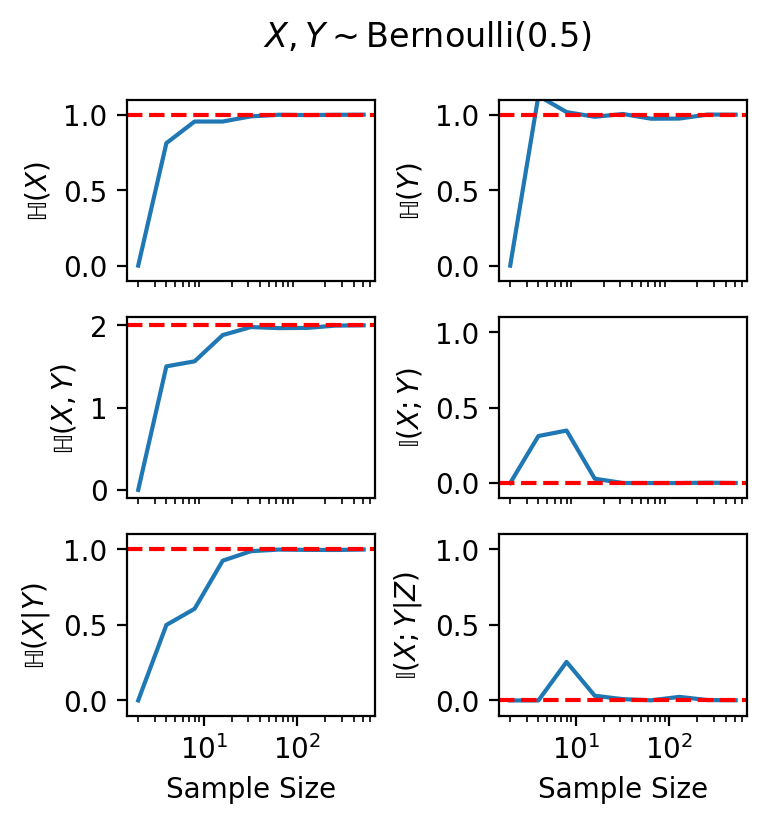

In [1]:
from experiments.it_diagnostic import drv_quantities
drv_quantities()

Next, I moved on to sequences of discrete random variables. Initially I naively tried scaling up the same numerical methods from the single DRV setting:
1. Rollout a sequence of 100 coin tosses ($X^{100}$)
2. Do this a 1000 times to get 1000 samples of $X^{100}$ as our dataset $\mathcal{D}$
3. Compute $\text{Pr}(X^n)$ in a frequentist manner
4. Plug $\text{Pr}(X^n)$ into the entropy formula $\mathbb{H}(X^{100}) = - \sum_{X^{100} \in \mathcal{D}} \text{Pr}(X^{100}) \log_2(\text{Pr}(X^{100}))$

The problem here is that the space of all possible $X^{100}$ is HUGE (of size $2^{100}$ for the Bernoulli sequences I was working with)! So all sequences in $\mathcal{D}$ were unique, and $\text{Pr}(X^{100})$ always looked like a uniform distribution, with entropy = $\log_2(1000) \approx 10 \, \text{bits}$.

So as I plotted this incorrect entropy as a function of $\log(\text{sample size})$, it went up linearly :`), instead of converging.

<img src="images/NaiveEntropySeq.png" alt="Incorrect entropy went up linearly with sample size :(" width="50%">

Side notes:
* Initially I tried using this undersampled entropy estimator straight away in the `LightRooms` env, but saw both plasticity and empowerment go up when a random agent entered rooms it could control better. This is when I knew there was a bug in my sequences code.
* I did find a less biased estimator of entropy than $\mathbb{H}(X) = - \sum_{X \in \mathcal{X}} \text{Pr}(X) \log_2(\text{Pr}(X))$ (sometimes called the Maximum Liklihood Estimator of entropy), by adding a correction term called the _Miller-Madow correction_. This did help in the discerete random variable setting, but the undersampling error in the discrete random sequence setting was just too huge to fix with this term.